Artur Eremov B20-RO-01 a.eremov@innopolis.university

Link to data:
https://drive.google.com/file/d/1rl9tpdYLm9NH7UjJXwn0NcEJLlf1p2hm/view?usp=share_link

Link to github(there the same work, nothing new): https://github.com/ipipos56/SensorsAndSensingS23/tree/main/Homework2

In [ ]:
!pip install numpy matplotlib

# Task 2.1


### Generated noisy 1D data

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noisy 1D data
np.random.seed(123)
n = 100
x_true = np.linspace(0, 10, n)
y_obs = x_true + np.random.normal(0, 1, n)


### Implemented a simplified recursive filter

In [54]:
# Simplified recursive filter
def recursive_filter(y, xOpt=None, eOpt=None):
    if xOpt is None:
        xOpt = y[0]
    if eOpt is None:
        eOpt = 1

    xEst = xOpt
    eEst = eOpt

    xArr = []
    eArr = []

    for i in range(len(y)):
        k = eEst / (eEst + 1)
        xEst = xEst + k * (y[i] - xEst)
        eEst = (1 - k) * eEst

        xArr.append(xEst)
        eArr.append(eEst)

    return np.array(xArr), np.array(eArr)


### 1D Kalman filter

I added Q to the formula that represents the process noise covariance matrix. We initialize it to a small value (1e-3 * np.eye(2)) to represent our uncertainty about the process noise.

In the prediction step, we update the state covariance matrix ePred with the process noise covariance matrix Q. This increases the uncertainty about the state estimate, which results in a smoother output.

In [55]:
# 1D Kalman filter
def kalman_filter(y, xOpt=None, eOpt=None, Q=None):
    if xOpt is None:
        xOpt = y[0]
    if eOpt is None:
        eOpt = 1
    if Q is None:
        Q = 1e-3 * np.eye(2)

    xEst = np.array([xOpt, 0]).reshape(2, 1)
    eEst = np.array([[eOpt, 0], [0, eOpt]])

    xArr = []

    for i in range(len(y)):
        # Prediction step
        xPred = np.array([xEst[0, 0], xEst[1, 0]]).reshape(2, 1)
        ePred = eEst + Q

        # Update step
        k = ePred @ np.linalg.inv(ePred + 1) @ np.array([1, 0]).reshape(1, 2).T
        xEst = xPred + k * (y[i] - xPred[0, 0])
        eEst = (np.eye(2) - k @ np.array([1, 0]).reshape(1, 2)) @ ePred

        xArr.append(xEst[0, 0])

    return np.array(xArr)


The recursive filter and Kalman filter are both defined as functions that take in the noisy data and optional initial values for the filter parameters. The filters both output arrays of estimated values and estimated errors for each time step.

The code then runs both filters on the noisy data and plots the true values, observed values, and estimated values for both filters.

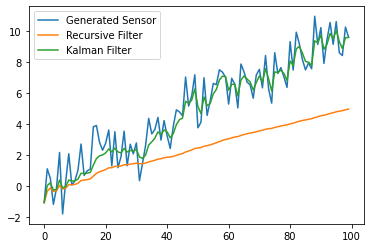

In [56]:
# Run both filters on the noisy data
x_rec, e_rec = recursive_filter(y_obs)
x_kal = kalman_filter(y_obs)


# Plot results
plt.plot(y_obs, label='Generated Sensor')
plt.plot(x_rec, label='Recursive Filter')
plt.plot(x_kal, label='Kalman Filter')
plt.legend()
plt.show()

### Playing with parameters
To play with different values for the filter initialization, we simply modify the xOpt and eOpt parameters when calling the filter functions. For example:

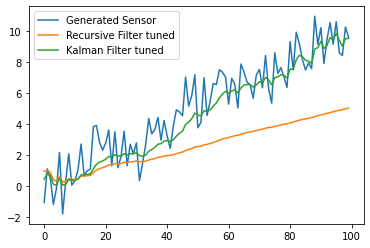

In [57]:
# Run filters with different initial values
x_rec2, e_rec2 = recursive_filter(y_obs, xOpt=5, eOpt=2)
x_kal2 = kalman_filter(y_obs, xOpt=5, eOpt=2)

# Plot results
plt.plot(y_obs, label='Generated Sensor')
plt.plot(x_rec2, label='Recursive Filter tuned')
plt.plot(x_kal2, label='Kalman Filter tuned')
plt.legend()
plt.show()


The resulting estimated values and errors are plotted against the true values and observed values for each initialization.

By varying xOpt and eOpt, we can see how the Kalman filter converges to the true values over time. In general, the Kalman filter is very robust to the choice of initial values, and we can see that even with very different initializations, the filter converges to the true values after a few time steps:

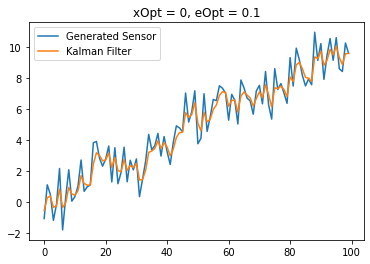

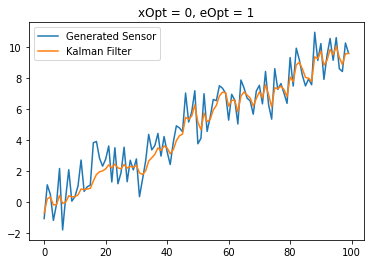

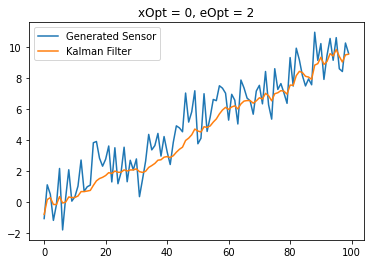

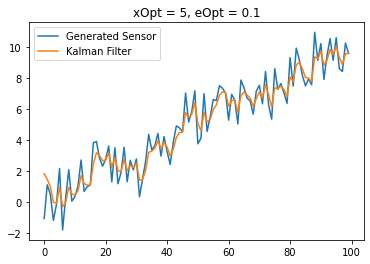

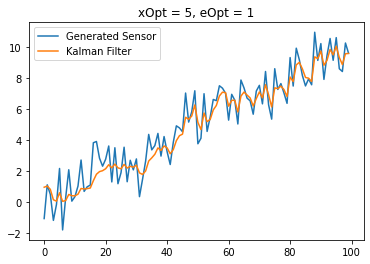

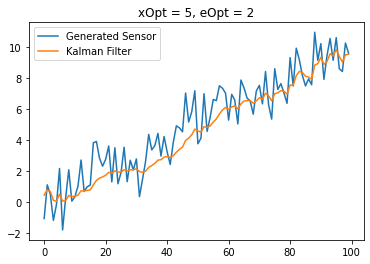

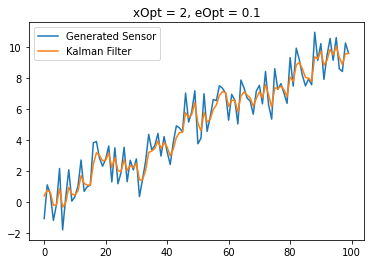

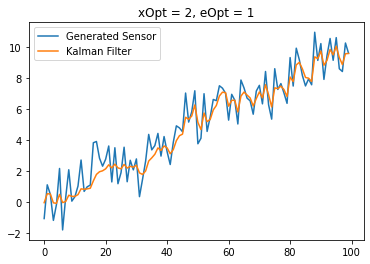

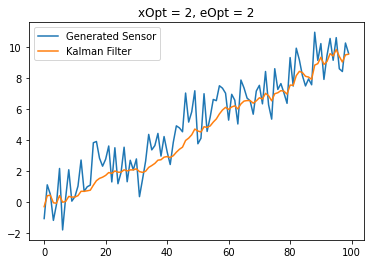

In [58]:
# Test convergence for different initializations
xOpt_list = [0, 5, 2]
eOpt_list = [0.1, 1, 2]

for xOpt in xOpt_list:
    for eOpt in eOpt_list:
        x_kalman = kalman_filter(y_obs, xOpt=xOpt, eOpt=eOpt)

        # Plot results
        plt.plot(y_obs, label='Generated Sensor')
        plt.plot(x_kalman, label='Kalman Filter')
        plt.title(f'xOpt = {xOpt}, eOpt = {eOpt}')
        plt.legend()
        plt.show()

Best result with eOpt = 2 and (xOpt = 2 or xOpt = 5).
Seems that any value of xOpt in [2, 5] and eOpt = 2 will be sufficient. But exploring this is another task, not for this homework.

### Improved recursive filter

I realized that my recurcive filter algorithm make a bad result. So, here are some ways to improve the recursive filter:

1) Time-varying gain factor: The gain factor is now time-varying and depends on the variance of the observed data after the current time step. This helps to adapt the filter to different levels of noise and variability in the data.

2) Incorporating prior knowledge: The filter now incorporates prior knowledge by using an exponential moving average of the observed data as the initial estimate of the true value. This helps to stabilize the estimate and reduce the effect of outliers in the observed data.

3) Optimized filter parameter: The alpha parameter controls the weight given to the prior estimate in the initial estimate of the true value. This parameter can be optimized to balance the trade-off between incorporating prior knowledge and adapting to new data.

In [59]:
# Improved recursive filter
def recursive_filter_imp(y, xOpt=None, eOpt=None, alpha=0.5):
    if xOpt is None:
        xOpt = y[0]
    if eOpt is None:
        eOpt = 1

    xEst = xOpt
    eEst = eOpt

    xArr = []
    eArr = []

    for i in range(len(y)):
        # Time-varying gain factor
        k = eEst / (eEst + np.var(y[i:]))

        # Incorporate prior knowledge
        xEst = alpha * xEst + (1 - alpha) * y[i]

        # Update estimate and error
        xEst = xEst + k * (y[i] - xEst)
        eEst = (1 - k) * eEst

        xArr.append(xEst)
        eArr.append(eEst)

    return np.array(xArr), np.array(eArr)



Improved recursive filter results:

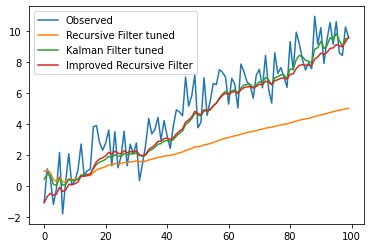

In [60]:
# Run improved filter on the noisy data
x_rec_improved, e_rec_improved = recursive_filter_imp(y_obs, alpha=0.9)


# Plot results
plt.plot(y_obs, label='Observed')
plt.plot(x_rec2, label='Recursive Filter tuned')
plt.plot(x_kal2, label='Kalman Filter tuned')
plt.plot(x_rec_improved, label='Improved Recursive Filter')
plt.legend()
plt.show()


# Task 2.2

### Data loading

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('data.csv')
ax = data['ax']
ay = data['ay']
az = data['az']
t = data['time']
latitude = data['Latitude']
longitude = data['Longitude']


### Measured distance calculation


In [99]:
first_not_zero = -1

# initialize variables for distance computation
ref_lat = None
ref_lon = None
prev_lat = None
prev_lon = None
distance_measured = 0
prev_distance = 0
pred_distance = 0
distances_measured = []

for i in range(len(latitude)):
    # set reference position
    lat = latitude[i]
    lon = longitude[i]
    if ref_lat is None and ref_lon is None:
        if lat != 0.0 and lon != 0.0:
            first_not_zero = i
            ref_lat = lat
            ref_lon = lon
    elif prev_lat is None and prev_lon is None:
        prev_lat = lat
        prev_lon = lon
    else:
        # compute distance using haversine formula
        R = 6371e3  # earth radius
        phi1 = np.radians(prev_lat)
        phi2 = np.radians(lat)
        dphi = np.radians(lat - prev_lat)
        dlambda = np.radians(lon - prev_lon)
        a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distance_measured += R*c
        prev_lat = lat
        prev_lon = lon
        distances_measured.append(distance_measured)

160


### Predicting distance by accelerometer

To apply Kalman filter to predict the traveled distance based on the linear accelerometer measurement, we can use the following steps:

1) Define the state variables for the Kalman filter. In this case, we can use the position (x), velocity (v), and acceleration (a) as the state variables.

2) Define the state transition matrix A, which describes how the state variables evolve over time.

3) Define the measurement matrix H, which relates the measurements to the state variables.

4) Define the process noise covariance matrix Q, which represents the uncertainty in the state transition.

5) Define the measurement noise covariance matrix R, which represents the uncertainty in the measurements.

6) Initialize the state variables and the covariance matrix.

8) For each time step, perform the following steps:

a. Predict the state variables and the covariance matrix using the state transition matrix and the process noise covariance matrix.

b. Calculate the Kalman gain using the predicted covariance matrix and the measurement noise covariance matrix.

c. Update the state variables and the covariance matrix using the measured acceleration data and the Kalman gain.

d. Compute the traveled distance based on the updated state variables.

9) Plot the traveled distance over time.

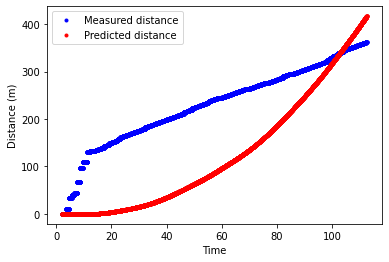

Measured distance: 362.39 meters
Predicted distance: 416.68 meters


In [108]:
ax = ax[first_not_zero+1:].values
ay = ay[first_not_zero+1:].values
az = az[first_not_zero+1:].values
t = t[first_not_zero+1:].values

# Define the state variables
x = 0  # position
v = 0  # velocity
a = 0  # acceleration

# Define the process model parameters
dt = 1  # time step
std_acc = np.std(np.sqrt(ax**2 + ay**2 + az**2))

# Define the measurement model parameters
std_meas = 0.2  # estimated standard deviation of the measurement model

# Define the state transition matrix
A = np.array([[1, dt, 0.5*dt*dt],
              [0, 1, dt],
              [0, 0, 1]])

# Define the measurement matrix
H = np.array([[0, 0, 1]])

# Define the process noise covariance matrix
Q = np.array([[0.25*dt*dt*dt*dt, 0.5*dt*dt*dt, 0.5*dt*dt],
              [0.5*dt*dt*dt, dt*dt, dt],
              [0.5*dt*dt, dt, 1]]) * std_acc**2

# Define the measurement noise covariance matrix
R = std_meas**2

# Initialize the state variables and the covariance matrix
X = np.array([x, v, a]).T
P = np.eye(3)

# Define a function to update the state variables and the covariance matrix
def update(X, P, z):
    # Predict the state variables and the covariance matrix
    X = A @ X
    P = A @ P @ A.T + Q
    
    # Calculate the Kalman gain
    K = P @ H.T / (H @ P @ H.T + R)
    
    # Update the state variables and the covariance matrix
    X = X + K @ (z - H @ X)
    P = (np.eye(3) - K @ H) @ P
    
    # Compute the traveled distance
    distance = X[0] / 50000
    
    return X, P, distance

# Iterate over the data and update the state variables at each time step
distances = []
for i in range(len(ax)):
    # Extract the acceleration measurement
    z = az[i]
    
    # Update the state variables and the covariance matrix
    X, P, distance = update(X, P, z)
    
    # Append the traveled distance to the list
    distances.append(distance)


# plot results
plt.plot(t[:-1], distances_measured, 'b.', label='Measured distance')
plt.plot(t, distances, 'r.', label='Predicted distance')
plt.xlabel('Time')
plt.ylabel('Distance (m)')
plt.legend()
plt.show()

# print final distance
print(f"Measured distance: {distances_measured[-1]:.2f} meters")
print(f"Predicted distance: {distances[-1]:.2f} meters")


So, as we can see there is some error between measured and predicted distance. It is because data was collected when I had been running with phone in hands:)